## Load libraries

In [1]:
library(plyr)
library(dplyr)
library(ggplot2)
library(RColorBrewer)
library(reshape)
library(reshape2)
library(tidyverse)
library(scatterpie)
library(repr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘reshape’


The following object is masked from ‘package:dplyr’:

    rename


The following objects are masked from ‘package:plyr’:

    rename, round_any



Attaching package: ‘reshape2’


The following objects are masked from ‘package:reshape’:

    colsplit, melt, recast


── Attaching packages ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.5
✔ tidyr   1.2.1     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────────────────────────────────────────────

## Set paths to reference files

In [2]:
#Color scale
pie_cols=c("Primary_tumor"="#377EB8","Met_tumor"="#E41A1C","Normal"="#4DAF4A")

#List of metastatic samples
met_samples=c('CM1563C1-T1Y1','CM268C1-T1','CM618C1-T1Y2','CM663C1-T1Y1','CPT1541DU-T1','CPT2373DU-T1','CPT4096DU-T1','CPT4427DU-T1','CPT704DU-T1')

#Table with cells and clusters annotation
tab=read.table('../data/snATAC/Cluster_annotation_9EMTcases.20230122.tsv',sep='\t',header=T)

In [3]:
tab=tab[tab$clusters_to_use!='Other',]
tab$Count=1

#Update celltype_to_use for the summary plot:
#use celltype_to_use.v2 (which set to Other cells that had inconsistent annotation with the merged obj, 66 cells across all objects): 
tab$celltype_to_use=tab$celltype_to_use.v2
tab$celltype_to_use=ifelse(tab$celltype_to_use=='Tumor' & tab$Sample %in% met_samples, 
                           "Met_tumor",tab$celltype_to_use)
tab$celltype_to_use=ifelse(tab$celltype_to_use=='Tumor' & !(tab$Sample %in% met_samples), 
                           "Primary_tumor",tab$celltype_to_use)
tab$celltype_to_use=ifelse(tab$celltype_to_use %in% 
                           c('Ciliated Endometrial epithelial cells','Secretory Endometrial epithelial cells',
                             'Normal epithelial cells'),'Normal',tab$celltype_to_use)
tab$cluster_ID=paste(tab$Case,tab$clusters_to_use,sep='_')

In [4]:
#Annotate clusters
stat=aggregate(tab$Count, by=list(tab$cluster_ID,tab$celltype_to_use),FUN='sum')
colnames(stat)=c('cluster_ID','cell_type','Count')
stat_1=aggregate(tab$Count, by=list(tab$cluster_ID),FUN='sum')
colnames(stat_1)=c('cluster_ID','Total')

In [5]:
#Add metastatic cell fraction per cluster annotation
stat=merge(stat,stat_1,all.x=T)
stat$Freq=stat$Count/stat$Total
stat_s=stat[stat$Freq>0.5,]
stat_s$Met_fraction=ifelse(stat_s$cell_type=='Met_tumor',stat_s$Freq,1-stat_s$Freq)

In [6]:
#we want to re-label clusters, so that the first one will be Normal, then Primary, then Met 
#(shared clusters between Primary/Met would be ordered by the fraction of Met tumor cells).
stat_s2=stat_s
stat_s2$Case=gsub('(.*)_(.*)','\\1',stat_s2$cluster_ID)
stat_s2$Met_fraction=ifelse(stat_s2$cell_type=='Normal',0,stat_s2$Met_fraction)

In [7]:
stat_n=stat[stat$cell_type=='Normal' & stat$Freq>0.1,]
stat_s2$ID_2=stat_s2$cell_type
stat_s2$ID_2=ifelse(stat_s2$cluster_ID %in% stat_n$cluster_ID,'Normal',stat_s2$ID_2)

In [8]:
#Order by cell type, and then by Met fraction.

all_stat_s3=NULL
for(case in unique(stat_s2$Case)){
    stat_s3=stat_s2[stat_s2$Case==case & stat_s2$Total>50,]
    stat_s3=stat_s3[order(stat_s3$Met_fraction),]
    stat_s3=stat_s3 %>% mutate(ID_2=factor(ID_2,levels=c('Normal','Primary_tumor','Met_tumor'))) %>% arrange(ID_2)
    stat_s3$New_label=paste("C",c(1:nrow(stat_s3)),sep="")
    stat_s3$New_cluster_ID=paste(stat_s3$Case,stat_s3$New_label,sep='_')
    all_stat_s3=rbind(all_stat_s3,stat_s3)
}
all_stat_s3=as.data.frame(all_stat_s3)

In [9]:
#Add new cluster id annotation
stat_upd=merge(stat[stat$Total>50,],all_stat_s3[,c('cluster_ID','New_cluster_ID')],all.x=T)
to_plot=stat_upd
to_plot$Case=gsub('(.*)_(.*)','\\1',to_plot$New_cluster_ID)
to_plot$Cluster=gsub('(.*)_(.*)','\\2',to_plot$New_cluster_ID)

In [10]:
to_plot=to_plot[to_plot$cell_type!='Other',]
to_plot_1=dcast(data=to_plot, New_cluster_ID~cell_type,value.var='Count')
to_plot_1[is.na(to_plot_1)]<-0
to_plot_1$Case=gsub('(.*)_(.*)','\\1',to_plot_1$New_cluster_ID)
to_plot_1$Cluster=gsub('(.*)_(.*)','\\2',to_plot_1$New_cluster_ID)
to_plot_1$Total=rowSums(to_plot_1[,2:4])
to_plot_1$Cluster_toPlot=gsub('C','',to_plot_1$Cluster)

In [11]:
h1=to_plot_1[,c('New_cluster_ID','Case')]
h1=h1[!duplicated(h1$Case),]
case_order=c('CPT4427DU','CPT704DU','CPT4096DU','CPT1541DU','CPT2373DU','CM1563C','CM268C','CM618C','CM663C')
rownames(h1)=h1$Case
h1=h1[case_order,]
h1$Case_N=seq(1:9)
h1=h1[,-1]

In [12]:
to_plot_1=merge(to_plot_1,h1,all.x=T)
to_plot_1$Cluster_toPlot=as.numeric(as.character(unlist(to_plot_1$Cluster_toPlot)))

## Do plotting with scatterpie

In [13]:
p <- ggplot() 

p <- p + geom_scatterpie(aes(x=Cluster_toPlot*30, y=Case_N*40, r=log2(Total)), data=to_plot_1,
                                 cols=colnames(to_plot_1)[3:5], color='black') 

p <- p + coord_equal() +scale_fill_manual(values=pie_cols) +theme_classic()

p <- p + geom_scatterpie_legend(log2(to_plot_1$Total), x=150, y=200)

Warning message:
“Using the `size` aesthetic in this geom was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` in the `default_aes` field and elsewhere instead.”


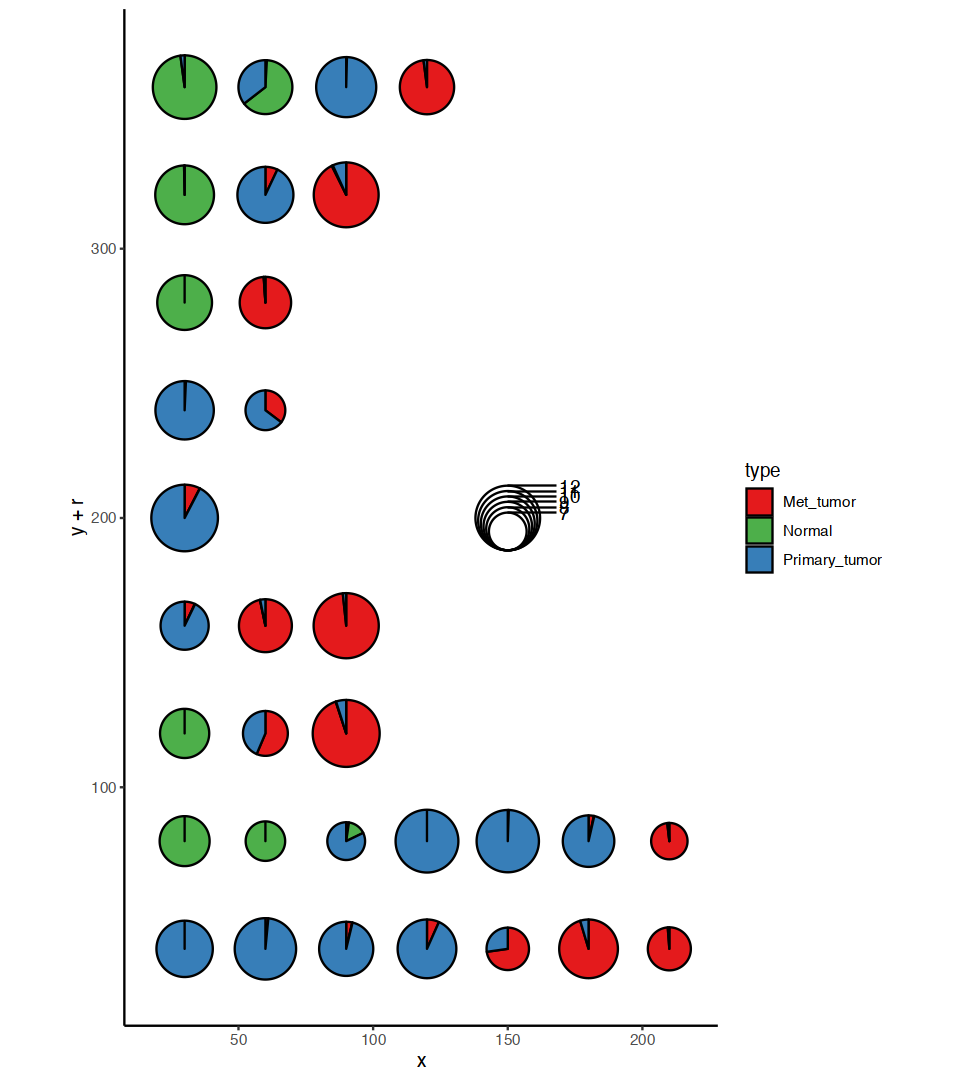

In [14]:
options(repr.plot.width=8, repr.plot.height=9)
p